In [1]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unrar x "/content/drive/MyDrive/news_20250225to20250510.rar" "content/"


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/news_20250225to20250510.rar

Creating    content                                                   OK
Extracting  content/news_20250225to20250510.csv                            2%  5%  7% 10% 12% 15% 18% 20% 23% 25% 28% 31% 33% 36% 38% 41% 44% 46% 49% 51% 54% 57% 59% 62% 64% 67% 70% 72% 75% 77% 80% 82% 85% 88% 90% 93% 95% 98%100%  OK 
All OK


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/news_20250510to20250526.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
import pandas as pd
df_news1 = pd.read_csv('/content/content/news_20250225to20250510.csv')
df_news2 = pd.read_csv('news_20250510to20250526.csv')
df_news2 = df_news2[~df_news2['ID'].isin(df_news1['ID'])]
df_news_total = pd.concat([df_news1, df_news2])
df_news_total['time'] = pd.to_datetime(df_news_total['releasedAt']).dt.floor('min').astype(str)

df_news = df_news_total[df_news_total['asset_symbols'].apply(lambda x: ('BTC' in str(x)) or ('ETH' in str(x)))]
df_news[['releasedAt', 'time']]


,releasedAt,time
1,2025-02-25 00:00:00,2025-02-25 00:00:00
5,2025-02-25 00:00:00,2025-02-25 00:00:00
7,2025-02-25 00:00:00,2025-02-25 00:00:00
10,2025-02-25 00:00:10,2025-02-25 00:00:00
14,2025-02-25 00:01:00,2025-02-25 00:01:00
...,...,...
68193,2025-05-25 23:40:38,2025-05-25 23:40:00
68201,2025-05-25 23:47:19,2025-05-25 23:47:00
68205,2025-05-25 23:52:53,2025-05-25 23:52:00
68209,2025-05-25 23:55:31,2025-05-25 23:55:00


In [5]:
data_btc1 = pd.read_pickle('/content/drive/MyDrive/data_btc_1min.pickle')
data_btc2 = pd.read_pickle('/content/news_20250510to20250526.pickle')
data_btc2 = data_btc2[~data_btc2['dateTime'].isin(data_btc1['dateTime'])]
data_btc_total = pd.concat([data_btc1, data_btc2])
data_btc_total['time'] = data_btc_total['dateTime'].astype(str)

0.5005827259497225
0.49941727405027747


<Axes: >

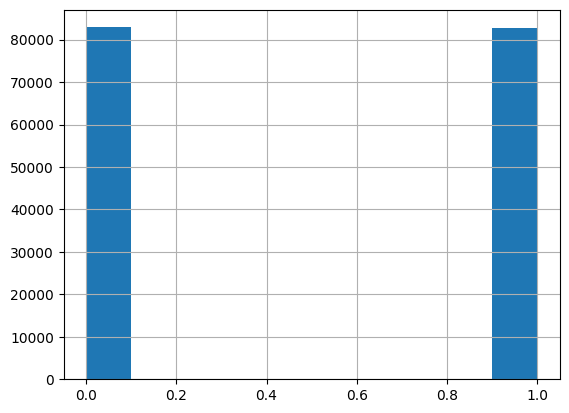

In [6]:
merged_data = data_btc_total.copy()


merged_data['prev_Returns'] = 100*((merged_data['close']-merged_data['close'].shift(1))/merged_data['close'])
merged_data['return'] = 100*merged_data['close'].pct_change()
merged_data['volatility'] = 10*merged_data['return'].rolling(30).std().shift(-30)

# merged_data['volatility'] = 100*((merged_data['close'].shift(-30)-merged_data['close'])/merged_data['close'])

threshold = 0.47
merged_data['return_class'] = 0
# merged_data.loc[abs(merged_data['volatility'])>threshold, 'return_class'] = 1
merged_data.loc[(merged_data['volatility'])>threshold, 'return_class'] = 1

# df.loc[df['return']<-threshold, 'return_class'] = 2

print((merged_data['return_class']==0).sum()/len(merged_data))
print((merged_data['return_class']==1).sum()/len(merged_data))
# print((df['return_class']==2).sum()/len(df))

merged_data['return_class'].hist()

In [7]:
merged_data['Volatility'] = merged_data['close'].pct_change(fill_method=None).rolling(5).std().fillna(0)

# Calculate Moving Averages
merged_data['SMA_5'] = merged_data['close'].rolling(window=5).mean()
merged_data['EMA_5'] = merged_data['close'].ewm(span=5, adjust=False).mean()
merged_data['SMA_10'] = merged_data['close'].rolling(window=10).mean()
merged_data['EMA_10'] = merged_data['close'].ewm(span=10, adjust=False).mean()
merged_data['SMA_20'] = merged_data['close'].rolling(window=20).mean()
merged_data['EMA_20'] = merged_data['close'].ewm(span=20, adjust=False).mean()
merged_data['EMA_50'] = merged_data['close'].ewm(span=50, adjust=False).mean()
merged_data['SMA_100'] = merged_data['close'].rolling(window=100).mean()
merged_data['EMA_100'] = merged_data['close'].ewm(span=100, adjust=False).mean()
merged_data['EMA_200'] = merged_data['close'].ewm(span=200, adjust=False).mean()

# Calculate Bollinger Bands
merged_data['Std_20'] = merged_data['close'].rolling(window=20).std()
merged_data['Upper_BB'] = merged_data['SMA_20'] + (2 * merged_data['Std_20'])
merged_data['Lower_BB'] = merged_data['SMA_20'] - (2 * merged_data['Std_20'])

# Add a Signal column (e.g., 1 if Close > SMA_20, else 0)
# Calculate MACD and Signal Line
# MACD Line = 12-period EMA - 26-period EMA
merged_data['EMA_12'] = merged_data['close'].ewm(span=12, adjust=False).mean()
merged_data['EMA_26'] = merged_data['close'].ewm(span=26, adjust=False).mean()
merged_data['MACD'] = merged_data['EMA_12'] - merged_data['EMA_26']

# Signal Line = 9-period EMA of MACD Line
merged_data['Signal'] = merged_data['MACD'].ewm(span=9, adjust=False).mean()


selected_f = ['open', 'high', 'low', 'close', 'volume', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol',
       'takerBuyQuoteVol', 'Volatility',
       'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'EMA_50',
       'SMA_100', 'EMA_100', 'EMA_200', 'Std_20', 'Upper_BB', 'Lower_BB',
       'prev_Returns', 'EMA_12', 'EMA_26', 'MACD', 'Signal']

for x in selected_f:
  merged_data[x] = merged_data[x].fillna(0)
  merged_data[x] = merged_data[x].astype(float)
  merged_data[x] = (merged_data[x]-merged_data[x].mean())/(merged_data[x].std())

In [8]:
merged_data = merged_data.dropna().reset_index().drop('index',axis=1)
data_stock = merged_data.copy()

In [9]:
selected_time = data_stock[(data_stock['time']>='2025-02-25 00:00:00') & (data_stock['dateTime']<'2025-05-25 01:44:00') & (~data_stock['time'].isin(df_news['time']))]['time'].sample(3000).to_list()

In [10]:
df_news2 = df_news.copy()
df_news2['releasedAt'] = df_news2['releasedAt'].astype(str)
based_len = df_news2.index[-1]
list_data = []
for i in range(len(selected_time)):
  dict_data = {}
  dict_data['id'] = based_len+1+i
  dict_data['title'] = 'There is no news'
  dict_data['content'] = 'There is no news'
  dict_data['time'] = selected_time[i]
  dict_data['releasedAt'] = selected_time[i]
  list_data.append(dict_data)
df_news2 = pd.concat([df_news2, pd.DataFrame(list_data)])
df_news2 = df_news2.sort_values('time').reset_index().drop('index', axis=1)
df_news2


,ID,releasedAt,title,subtitle,sourceName,sourceUrl,source,slug,asset_names,asset_slugs,asset_symbols,content,time,id
0,67bf0e677abefca47e66327e,2025-02-25 00:00:00,2025’s Crypto Battle: Altcoin vs. XRP and Bitc...,Digital currencies now play a key role in glob...,Crypto Front News,https://coinmarketcap.com/community/en/article...,coinmarketcap,blockdag-vs-bitcoin-xrp-which-crypto-holds-lon...,"Ethereum, Bitcoin, BlockDAG, XRP, One","ethereum, bitcoin, blockdag, xrp, gmix","ETH, BTC, BDAG, XRP, GMIX",Digital currencies now play a key role in glob...,2025-02-25 00:00:00,NaN
1,67bf0e677abefca47e663282,2025-02-25 00:00:00,Bitcoin Dives Below $90K Amid ETF Sell-Offs an...,"Bitcoin has dropped below $90,000 for the firs...",WalletInvestor,https://coinmarketcap.com/community/en/article...,coinmarketcap,bitcoin-dives-below-90k-amid-etf-sell-offs-and...,"Solana, ETF, Bitcoin, ETF, Shiba Inu","solana, etf, bitcoin, etfsol2024, shiba-inu","SOL, ETF, BTC, ETF, SHIB","Bitcoin has dropped below $90,000 for the firs...",2025-02-25 00:00:00,NaN
2,67bf0e677abefca47e663284,2025-02-25 00:00:00,4 Ways to Increase the Value of Crypto Assets,Cryptocurrency investments can be highly rewar...,WalletInvestor,https://coinmarketcap.com/community/en/article...,coinmarketcap,4-ways-to-increase-the-value-of-crypto-assets,"Bounty, Cryptocurrency, Million, Liquid, Rewards","bounty, cryptocurrency, million, liquid-networ...","BNTY, CCY, MM, LBTC, RWD",Cryptocurrency investments can be highly rewar...,2025-02-25 00:00:00,NaN
3,67bf0e677abefca47e66327c,2025-02-25 00:00:10,"Major Crypto News: XRP, SOLANA, and MAGACOINOF...",The Crypto Market’s Next Big Movers—Who’s Lead...,Bitcoin Sistemi,https://coinmarketcap.com/community/en/article...,coinmarketcap,major-crypto-news-xrp-solana-and-magacoinoffic...,"Ethereum, Win, Major, Solana, XRP","ethereum, connect-united, major, solana, xrp","ETH, WIN, MAJOR, SOL, XRP",The Crypto Market’s Next Big Movers—Who’s Lead...,2025-02-25 00:00:00,NaN
4,67bf0e677abefca47e663278,2025-02-25 00:01:00,"XRP on Verge of Losing Crucial Support, Ethere...",Numerous assets are reaching levels that might...,U.Today,https://coinmarketcap.com/community/en/article...,coinmarketcap,xrp-on-verge-of-losing-crucial-support-ethereu...,"Ethereum, Dogecoin, bullish, Dogecoin, XRP","ethereum, doge-on-base, bullish, dogecoin, xrp","ETH, DOGE, BULLISH, DOGE, XRP",Cover image viaU.TodayWith its price hovering ...,2025-02-25 00:01:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38974,6833ac73040d6fffd0a49f14,2025-05-25 23:40:38,Metaplanet Tops SBI Securities NISA Stock Purc...,Metaplanet leads as top stock purchase in Japa...,CoinLineup,https://coinmarketcap.com/community/en/article...,coinmarketcap,metaplanet-sbi-securities-nisa-stock,"Bitcoin, Top, Read, CEO","bitcoin, top-protocol, read, ceo","BTC, TOP, READ, CEO","Key Points:Metaplanet leads NISA purchases, si...",2025-05-25 23:40:00,NaN
38975,6833addc51e12bb49bc9cc37,2025-05-25 23:47:19,Bitcoin Halving Post-2024 Sparks Consolidation...,The 2024 Bitcoin halving event triggers signif...,TokenTopNews,https://coinmarketcap.com/community/en/article...,coinmarketcap,bitcoin-halving-2024-market-analysis,"2024, 2024, Bitcoin, Read","2024-token, 2024-bsc, bitcoin, read","2024, 2024, BTC, READ",Key Takeaways:Bitcoin post-halving consolidati...,2025-05-25 23:47:00,NaN
38976,6833af44d4ba08aec29a16cf,2025-05-25 23:52:53,Spot Bitcoin ETFs Achieve $25 Billion Weekly V...,U.S. spot Bitcoin ETFs reach $25 billion in we...,Bitcoin Info News,https://coinmarketcap.com/community/en/article...,coinmarketcap,bitcoin-etfs-25-billion-volume,"Bitcoin ETF, Bitcoin, Read, Spot, BlackRock","bitcoin-etf-token, bitcoin, read, spot, blackrock","ETF, BTC, READ, SPOT, BLACKROCK",What to Know:Record trading volume in U.S. Bit...,2025-05-25 23:52:00,NaN
38977,6833af44d4ba08aec29a16cd,2025-05-25 23:55:31,"Trump Postpones EU Tariffs, Bitcoin Breaks $10...",Trump delays EU tariffs to July; Bitcoin rises...,Coincu,https:/

In [11]:
# data_stock = data_btc_total.copy()
data_stock['my_id'] = data_stock.index
df_news2 = df_news2.merge(data_stock[['my_id', 'time', 'return_class']], on='time', how='left')
df_news2

,ID,releasedAt,title,subtitle,sourceName,sourceUrl,source,slug,asset_names,asset_slugs,asset_symbols,content,time,id,my_id,return_class
0,67bf0e677abefca47e66327e,2025-02-25 00:00:00,2025’s Crypto Battle: Altcoin vs. XRP and Bitc...,Digital currencies now play a key role in glob...,Crypto Front News,https://coinmarketcap.com/community/en/article...,coinmarketcap,blockdag-vs-bitcoin-xrp-which-crypto-holds-lon...,"Ethereum, Bitcoin, BlockDAG, XRP, One","ethereum, bitcoin, blockdag, xrp, gmix","ETH, BTC, BDAG, XRP, GMIX",Digital currencies now play a key role in glob...,2025-02-25 00:00:00,NaN,34559,1
1,67bf0e677abefca47e663282,2025-02-25 00:00:00,Bitcoin Dives Below $90K Amid ETF Sell-Offs an...,"Bitcoin has dropped below $90,000 for the firs...",WalletInvestor,https://coinmarketcap.com/community/en/article...,coinmarketcap,bitcoin-dives-below-90k-amid-etf-sell-offs-and...,"Solana, ETF, Bitcoin, ETF, Shiba Inu","solana, etf, bitcoin, etfsol2024, shiba-inu","SOL, ETF, BTC, ETF, SHIB","Bitcoin has dropped below $90,000 for the firs...",2025-02-25 00:00:00,NaN,34559,1
2,67bf0e677abefca47e663284,2025-02-25 00:00:00,4 Ways to Increase the Value of Crypto Assets,Cryptocurrency investments can be highly rewar...,WalletInvestor,https://coinmarketcap.com/community/en/article...,coinmarketcap,4-ways-to-increase-the-value-of-crypto-assets,"Bounty, Cryptocurrency, Million, Liquid, Rewards","bounty, cryptocurrency, million, liquid-networ...","BNTY, CCY, MM, LBTC, RWD",Cryptocurrency investments can be highly rewar...,2025-02-25 00:00:00,NaN,34559,1
3,67bf0e677abefca47e66327c,2025-02-25 00:00:10,"Major Crypto News: XRP, SOLANA, and MAGACOINOF...",The Crypto Market’s Next Big Movers—Who’s Lead...,Bitcoin Sistemi,https://coinmarketcap.com/community/en/article...,coinmarketcap,major-crypto-news-xrp-solana-and-magacoinoffic...,"Ethereum, Win, Major, Solana, XRP","ethereum, connect-united, major, solana, xrp","ETH, WIN, MAJOR, SOL, XRP",The Crypto Market’s Next Big Movers—Who’s Lead...,2025-02-25 00:00:00,NaN,34559,1
4,67bf0e677abefca47e663278,2025-02-25 00:01:00,"XRP on Verge of Losing Crucial Support, Ethere...",Numerous assets are reaching levels that might...,U.Today,https://coinmarketcap.com/community/en/article...,coinmarketcap,xrp-on-verge-of-losing-crucial-support-ethereu...,"Ethereum, Dogecoin, bullish, Dogecoin, XRP","ethereum, doge-on-base, bullish, dogecoin, xrp","ETH, DOGE, BULLISH, DOGE, XRP",Cover image viaU.TodayWith its price hovering ...,2025-02-25 00:01:00,NaN,34560,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38974,6833ac73040d6fffd0a49f14,2025-05-25 23:40:38,Metaplanet Tops SBI Securities NISA Stock Purc...,Metaplanet leads as top stock purchase in Japa...,CoinLineup,https://coinmarketcap.com/community/en/article...,coinmarketcap,metaplanet-sbi-securities-nisa-stock,"Bitcoin, Top, Read, CEO","bitcoin, top-protocol, read, ceo","BTC, TOP, READ, CEO","Key Points:Metaplanet leads NISA purchases, si...",2025-05-25 23:40:00,NaN,164139,1
38975,6833addc51e12bb49bc9cc37,2025-05-25 23:47:19,Bitcoin Halving Post-2024 Sparks Consolidation...,The 2024 Bitcoin halving event triggers signif...,TokenTopNews,https://coinmarketcap.com/community/en/article...,coinmarketcap,bitcoin-halving-2024-market-analysis,"2024, 2024, Bitcoin, Read","2024-token, 2024-bsc, bitcoin, read","2024, 2024, BTC, READ",Key Takeaways:Bitcoin post-halving consolidati...,2025-05-25 23:47:00,NaN,164146,0
38976,6833af44d4ba08aec29a16cf,2025-05-25 23:52:53,Spot Bitcoin ETFs Achieve $25 Billion Weekly V...,U.S. spot Bitcoin ETFs reach $25 billion in we...,Bitcoin Info News,https://coinmarketcap.com/community/en/article...,coinmarketcap,bitcoin-etfs-25-billion-volume,"Bitcoin ETF, Bitcoin, Read, Spot, BlackRock","bitcoin-etf-token, bitcoin, read, spot, blackrock","ETF, BTC, READ, SPOT, BLACKROCK",What to Know:Record trading volume in U.S. Bit...,2025-05-25 23:52:00,NaN,164151,0
38977,6833af44d4ba08aec29a16cd,2025-05-25 23:55:31,"Trump Postpones EU Ta

<Axes: >

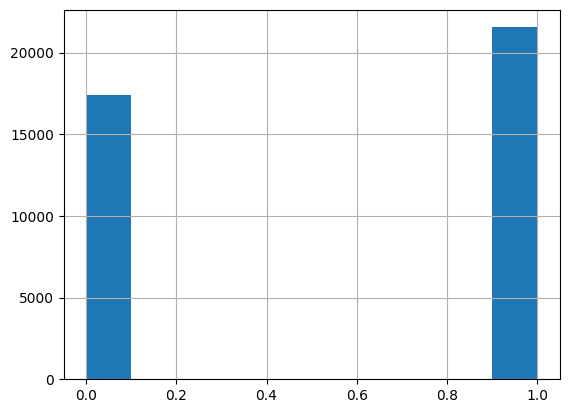

In [12]:
df_news2 = df_news2[~df_news2['my_id'].isna()].copy()
df_news2['return_class'].hist()

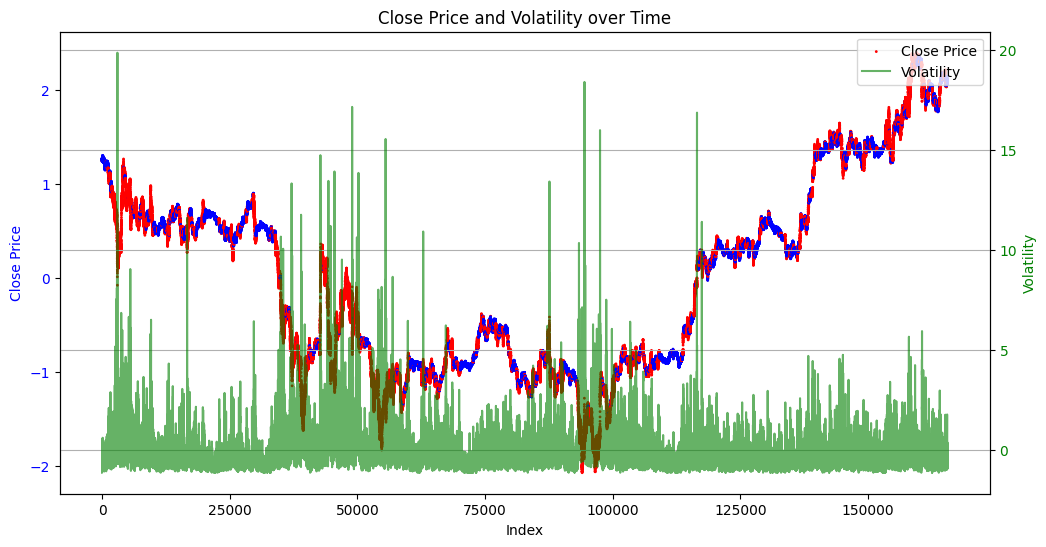

In [13]:
# prompt: plot close column of data_stocks and show return_class with value 1 as red point, and value 0 with blue point with low size. also plot Volatility in same figure but with different axis scale

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot 'close' with different colors and sizes based on 'return_class'
scatter = ax1.scatter(
    data_stock.index,
    data_stock['close'],
    c=data_stock['return_class'],
    cmap='bwr', # Blue-White-Red colormap
    s=1*data_stock['return_class'].apply(lambda x: 1 if x == 1 else 1), # Adjust size based on return_class
    label='Close Price'
)
ax1.set_xlabel('Index')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Close Price and Volatility over Time')


# Create a secondary axis for 'Volatility'
ax2 = ax1.twinx()
ax2.plot(data_stock.index, data_stock['Volatility'], label='Volatility', color='green', alpha=0.6)
ax2.set_ylabel('Volatility', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legend for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)


plt.grid(True)
plt.show()


In [14]:
seq_len = 30

list_ohlcv = []
for i in range(len(df_news2)):
  my_id = df_news2.iloc[i]['my_id']
  dict_ohlcv = {}
  dict_ohlcv[my_id] = data_stock.iloc[my_id-seq_len+1:my_id+1]
  list_ohlcv.append(data_stock.iloc[my_id-seq_len+1:my_id+1][selected_f].values)

input_text = 'content'
target_text = 'return_class'
df_text_input = df_news2[[input_text, target_text]].rename(columns={input_text:'text', target_text:'label'}).copy()

df_text_input = df_text_input.iloc[:20000]
list_ohlcv = list_ohlcv[:20000]

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel



class NewsMarketFusionDataset(torch.utils.data.Dataset):
    def __init__(self, df_text_input, list_ohlcv, selected_features, tokenizer, seq_len=30, max_text_len=512):
        self.df_text_input = df_text_input.reset_index(drop=True)
        self.df_ohlcv = list_ohlcv
        self.selected_features = selected_features
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.max_text_len = max_text_len

    def __len__(self):
        return len(self.df_text_input)

    def __getitem__(self, idx):
        row = self.df_text_input.iloc[idx]

        # 1. Get OHLCV time series window ending at my_id
        ohlcv_seq = self.df_ohlcv[idx]
        ohlcv_seq = torch.tensor(ohlcv_seq, dtype=torch.float32)  # shape [seq_len, num_features]

        # 2. Tokenize text
        text = row['text'] if pd.notna(row['text']) else ""
        encoding = self.tokenizer(text, padding='max_length', truncation=True,
                                  max_length=self.max_text_len, return_tensors='pt')
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        # 3. Get label
        label = torch.tensor(row['label'], dtype=torch.long)  # change dtype for classification

        return ohlcv_seq, input_ids, attention_mask, label





In [16]:
import math
import torch.nn as nn
import torch

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # [d_model/2]

        pe[:, 0::2] = torch.sin(position * div_term)  # even dims
        pe[:, 1::2] = torch.cos(position * div_term)  # odd dims
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerReturnPredictor(nn.Module):
    def __init__(self, feature_dim, d_model=64, nhead=4, num_layers=2, max_len=500):
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [batch_size, seq_len, feature_dim]
        x = self.input_proj(x)             # [batch_size, seq_len, d_model]
        x = self.pos_encoder(x)            # Add positional encoding
        x = self.transformer(x)            # [batch_size, seq_len, d_model]
        x = x[:, -1, :]                    # Use representation of last time step
        return self.output_layer(x).squeeze(-1)


In [17]:
from transformers import AutoModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm

class MarketNewsFusionModel(nn.Module):
    def __init__(self, finbert_model_name, feature_dim, d_model=64, nhead=4, num_layers=2, max_len=30, num_classes=2):
        super().__init__()

        # OHLCV Transformer
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # FinBERT
        self.finbert = AutoModel.from_pretrained(finbert_model_name)
        self.finbert_proj = nn.Linear(self.finbert.config.hidden_size, d_model)

        # Classifier
        self.classifier = nn.Linear(d_model * 2, num_classes)

    def forward(self, ohlcv_seq, input_ids, attention_mask):
        # Transformer on OHLCV
        x = self.input_proj(ohlcv_seq)           # [B, T, d_model]
        x = self.pos_encoder(x)
        x = self.transformer(x)                  # [B, T, d_model]
        x_market = x[:, -1, :]                   # [B, d_model]

        # FinBERT [CLS] embedding
        with torch.set_grad_enabled(self.training):
            outputs = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
            cls_embed = outputs.last_hidden_state[:, 0, :]  # [B, hidden]
        x_news = self.finbert_proj(cls_embed)               # [B, d_model]

        # Combine and classify
        fusion = torch.cat([x_market, x_news], dim=-1)      # [B, d_model*2]
        out = self.classifier(fusion)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = df_news2[target_text].nunique()

model_name = "yiyanghkust/finbert-tone"
# model_name = "google/bigbird-roberta-base"

model = MarketNewsFusionModel(model_name, feature_dim=len(selected_f), num_classes=2).to(device)
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=num_labels,
#     ignore_mismatched_sizes=True
# )

# optimizer = optim.AdamW(model.parameters(), lr=2e-5)
# lr_scheduler = get_scheduler(
#     "linear", optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=len(train_loader) * 10  # 10 epochs
# )

loss_fn = nn.CrossEntropyLoss()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [18]:
# model = MarketNewsFusionModel("yiyanghkust/finbert-tone", feature_dim=len(selected_f), num_classes=2).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_name)

split = int(0.8 * len(df_text_input))


train_dataset = NewsMarketFusionDataset(df_text_input.iloc[:split], list_ohlcv[:split], selected_features=selected_f, tokenizer=tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = NewsMarketFusionDataset(df_text_input.iloc[split:], list_ohlcv[split:], selected_features=selected_f, tokenizer=tokenizer)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)



for ohlcv_seq, input_ids, attention_mask, label in train_loader:
    ohlcv_seq = ohlcv_seq.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    label = label.to(device)

    out = model(ohlcv_seq, input_ids, attention_mask)
    loss = loss_fn(out, label)  # use BCEWithLogitsLoss or CrossEntropyLoss

    print(loss)
    break

vocab.txt: 0.00B [00:00, ?B/s]

tensor(0.6615, device='cuda:0', grad_fn=<NllLossBackward0>)


In [19]:
import numpy as np
import torch

# Assuming `df_news2['label']` holds your class labels
class_counts = np.bincount(df_text_input['label'].values)
print("Class counts:", class_counts)


class_counts = np.bincount(df_text_input['label'].values)
print("Class counts:", class_counts)
weights = 1.0 / class_counts
weights = (np.sum(class_counts)/np.max(class_counts))*(weights / weights.sum())
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)


Class counts: [ 5745 14255]
Class counts: [ 5745 14255]


In [20]:
class_weights

tensor([1.0000, 0.4030], device='cuda:0')

In [ ]:
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_loader) * 10
)

loss_fn = nn.CrossEntropyLoss()

# Assuming `df_news2['label']` holds your class labels
class_counts = np.bincount(df_text_input['label'].values)
print("Class counts:", class_counts)


class_counts = np.bincount(df_text_input['label'].values)
weights = 1.0 / class_counts
weights = (np.sum(class_counts)/np.max(class_counts))*(weights / weights.sum())
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

best_val_loss = float('inf')
patience = 3
patience_counter = 0
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for ohlcv_seq, input_ids, attention_mask, label in train_loader:
        ohlcv_seq = ohlcv_seq.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        label = label.to(device)

        out = model(ohlcv_seq, input_ids, attention_mask)
        loss = loss_fn(out, label)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    preds, labels = [], []
    with torch.no_grad():
        for ohlcv_seq, input_ids, attention_mask, label in val_loader:
            ohlcv_seq = ohlcv_seq.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)

            out = model(ohlcv_seq, input_ids, attention_mask)
            loss = loss_fn(out, label)
            val_loss += loss.item()

            logits = out  # Fixed here
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(label.cpu().numpy())  # Fixed here

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(labels, preds)
    val_f1 = f1_score(labels, preds, average='macro')

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.4f}, F1 = {val_f1:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_finbert.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Class counts: [ 5809 14191]
Epoch 1: Train Loss = 0.4490, Val Loss = 0.3986, Val Acc = 0.8045, F1 = 0.7449
Epoch 2: Train Loss = 0.3586, Val Loss = 0.3890, Val Acc = 0.8075, F1 = 0.7478
Epoch 3: Train Loss = 0.3192, Val Loss = 0.4232, Val Acc = 0.8053, F1 = 0.7445
Epoch 4: Train Loss = 0.2325, Val Loss = 0.5168, Val Acc = 0.8063, F1 = 0.7243
Epoch 5: Train Loss = 0.1283, Val Loss = 0.6716, Val Acc = 0.7785, F1 = 0.7094
Early stopping triggered.


# news and OHLCV next to each other

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer, get_scheduler
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# ----------------------
# Positional Encoding
# ----------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, T, d_model)
        length = x.size(1)
        x = x + self.pe[:, :length, :]
        return x

# ----------------------
# Model Definition
# ----------------------
class MarketNewsConcatModel(nn.Module):
    def __init__(
        self,
        finbert_model_name: str,
        feature_dim: int,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 2,
        max_len: int = 30,
        num_classes: int = 2
    ):
        super().__init__()
        # FinBERT backbone
        self.finbert = AutoModel.from_pretrained(finbert_model_name)
        hidden_size = self.finbert.config.hidden_size

        # Joint transformer input projection
        self.input_proj = nn.Linear(feature_dim + hidden_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classifier
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, ohlcv_seq, input_ids, attention_mask):
        B, T, _ = ohlcv_seq.size()
        # CLS from FinBERT
        bert_out = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embed = bert_out.last_hidden_state[:, 0, :]         # [B, H]
        # Tile across sequence length
        cls_tile = cls_embed.unsqueeze(1).repeat(1, T, 1)       # [B, T, H]
        # Concatenate and project
        aug_seq = torch.cat([ohlcv_seq, cls_tile], dim=-1)      # [B, T, F+H]
        x = self.input_proj(aug_seq)                           # [B, T, d_model]
        x = self.pos_encoder(x)
        x = self.transformer(x)                                # [B, T, d_model]
        # Classify using last time-step
        last = x[:, -1, :]                                      # [B, d_model]
        logits = self.classifier(last)                         # [B, num_classes]
        return logits

# ----------------------
# Usage & Training
# ----------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume selected_f, df_text_input, list_ohlcv are defined as before
model = MarketNewsConcatModel(
    finbert_model_name='yiyanghkust/finbert-tone',
    feature_dim=len(selected_f),
    num_classes=2
).to(device)

# Tokenizer (used by your NewsMarketFusionDataset)
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Train/validation split
split = int(0.8 * len(df_text_input))
train_dataset = NewsMarketFusionDataset(
    df_text_input.iloc[:split],
    list_ohlcv[:split],
    selected_features=selected_f,
    tokenizer=tokenizer
)
val_dataset = NewsMarketFusionDataset(
    df_text_input.iloc[split:],
    list_ohlcv[split:],
    selected_features=selected_f,
    tokenizer=tokenizer
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=True)

# Optimizer & Scheduler
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_scheduler(
    'linear', optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Class weights for imbalance
counts = np.bincount(df_text_input['label'].values)
weights = (counts.sum() / counts.max()) * (1.0 / counts)
weights = weights / weights.sum()
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
patience = 3

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    for ohlcv_seq, input_ids, attention_mask, label in tqdm(
        train_loader, desc=f"Epoch {epoch+1} Training"
    ):
        ohlcv_seq = ohlcv_seq.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        label = label.to(device)

        logits = model(ohlcv_seq, input_ids, attention_mask)
        loss = loss_fn(logits, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    preds, trues = [], []
    for ohlcv_seq, input_ids, attention_mask, label in tqdm(
        val_loader, desc=f"Epoch {epoch+1} Validation"
    ):
        ohlcv_seq = ohlcv_seq.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        label = label.to(device)

        with torch.no_grad():
            logits = model(ohlcv_seq, input_ids, attention_mask)
        total_val_loss += loss_fn(logits, label).item()
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        trues.extend(label.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(trues, preds)
    val_f1 = f1_score(trues, preds, average='macro')

    print(
        f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} "
        f"| Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}"
    )

    # Checkpoint & early stop
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_concat_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break


Epoch 1 Training:   0%|          | 0/500 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 44.12 MiB is free. Process 2589 has 14.70 GiB memory in use. Of the allocated memory 14.49 GiB is allocated by PyTorch, and 80.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

---

# projected news (64) and embedding next to eachother


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer, get_scheduler
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# ----------------------
# Positional Encoding
# ----------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (B, T, d_model)
        length = x.size(1)
        return x + self.pe[:, :length, :]

# ----------------------
# Projection-First Fusion Model
# ----------------------
class MarketNewsProjFirstModel(nn.Module):
    def __init__(
        self,
        finbert_model_name: str,
        feature_dim: int,
        k: int = 64,            # projected size for CLS
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 2,
        max_len: int = 30,
        num_classes: int = 2
    ):
        super().__init__()
        # FinBERT backbone + projection
        self.finbert = AutoModel.from_pretrained(finbert_model_name)
        self.finbert_proj = nn.Linear(self.finbert.config.hidden_size, k)

        # Joint Transformer for (OHLCV + projected CLS)
        self.input_proj = nn.Linear(feature_dim + k, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classifier
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, ohlcv_seq, input_ids, attention_mask):
        B, T, _ = ohlcv_seq.size()
        # a) Extract CLS from FinBERT
        bert_out = self.finbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_768 = bert_out.last_hidden_state[:, 0, :]          # [B, 768]
        # b) Project CLS to k dimensions
        cls_k = self.finbert_proj(cls_768)                    # [B, k]
        # c) Tile across sequence length
        cls_tile = cls_k.unsqueeze(1).repeat(1, T, 1)          # [B, T, k]
        # d) Concatenate OHLCV with projected CLS
        aug_seq = torch.cat([ohlcv_seq, cls_tile], dim=-1)     # [B, T, feature_dim + k]
        x = self.input_proj(aug_seq)                          # [B, T, d_model]
        x = self.pos_encoder(x)
        x = self.transformer(x)                               # [B, T, d_model]
        # e) Classify using last time-step
        logits = self.classifier(x[:, -1, :])                 # [B, num_classes]
        return logits

# ----------------------
# Training Setup
# ----------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Instantiate the projection-first model
model = MarketNewsProjFirstModel(
    finbert_model_name='yiyanghkust/finbert-tone',
    feature_dim=len(selected_f),
    k=64,
    d_model=64,
    num_classes=2
).to(device)

# 2) Tokenizer for dataset
tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# 3) Prepare DataLoaders (same as before)
split = int(0.8 * len(df_text_input))
train_dataset = NewsMarketFusionDataset(
    df_text_input.iloc[:split],
    list_ohlcv[:split],
    selected_features=selected_f,
    tokenizer=tokenizer
)
val_dataset = NewsMarketFusionDataset(
    df_text_input.iloc[split:],
    list_ohlcv[split:],
    selected_features=selected_f,
    tokenizer=tokenizer
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

# 4) Optimizer & Scheduler (ensure optimizer is defined correctly)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_scheduler(
    'linear', optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 5) Loss function with class weights
counts = np.bincount(df_text_input['label'].values)
weights = (counts.sum() / counts.max()) * (1.0 / counts)
weights = weights / weights.sum()
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# 6) Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
patience = 3

# 7) Training loop with tqdm
for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    for ohlcv_seq, input_ids, attention_mask, label in tqdm(
        train_loader, desc=f"Epoch {epoch+1} Training"
    ):
        ohlcv_seq, input_ids, attention_mask, label = (
            ohlcv_seq.to(device),
            input_ids.to(device),
            attention_mask.to(device),
            label.to(device)
        )
        optimizer.zero_grad()
        logits = model(ohlcv_seq, input_ids, attention_mask)
        loss = loss_fn(logits, label)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0
    preds, trues = [], []
    for ohlcv_seq, input_ids, attention_mask, label in tqdm(
        val_loader, desc=f"Epoch {epoch+1} Validation"
    ):
        ohlcv_seq, input_ids, attention_mask, label = (
            ohlcv_seq.to(device),
            input_ids.to(device),
            attention_mask.to(device),
            label.to(device)
        )
        with torch.no_grad():
            logits = model(ohlcv_seq, input_ids, attention_mask)
        total_val_loss += loss_fn(logits, label).item()
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        trues.extend(label.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(trues, preds)
    val_f1 = f1_score(trues, preds, average='macro')

    print(
        f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} "
        f"| Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}"
    )

    # Checkpoint & Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_proj_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1 Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.4308 | Val Loss: 0.4037 | Acc: 0.7580 | F1: 0.7116


Epoch 2 Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.3671 | Val Loss: 0.3437 | Acc: 0.8150 | F1: 0.7517


Epoch 3 Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.3473 | Val Loss: 0.3805 | Acc: 0.7940 | F1: 0.7398


Epoch 4 Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.2995 | Val Loss: 0.3911 | Acc: 0.8270 | F1: 0.7391


Epoch 5 Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.2030 | Val Loss: 0.5114 | Acc: 0.7827 | F1: 0.7149
Early stopping triggered.


# 30 window with 6 step - no news and news averaging per minute

In [ ]:
df_news2

,ID,releasedAt,title,subtitle,sourceName,sourceUrl,source,slug,asset_names,asset_slugs,asset_symbols,content,time,id,my_id,return_class
0,67bf0e677abefca47e66327e,2025-02-25 00:00:00,2025’s Crypto Battle: Altcoin vs. XRP and Bitc...,Digital currencies now play a key role in glob...,Crypto Front News,https://coinmarketcap.com/community/en/article...,coinmarketcap,blockdag-vs-bitcoin-xrp-which-crypto-holds-lon...,"Ethereum, Bitcoin, BlockDAG, XRP, One","ethereum, bitcoin, blockdag, xrp, gmix","ETH, BTC, BDAG, XRP, GMIX",Digital currencies now play a key role in glob...,2025-02-25 00:00:00,NaN,34559,1
1,67bf0e677abefca47e663282,2025-02-25 00:00:00,Bitcoin Dives Below $90K Amid ETF Sell-Offs an...,"Bitcoin has dropped below $90,000 for the firs...",WalletInvestor,https://coinmarketcap.com/community/en/article...,coinmarketcap,bitcoin-dives-below-90k-amid-etf-sell-offs-and...,"Solana, ETF, Bitcoin, ETF, Shiba Inu","solana, etf, bitcoin, etfsol2024, shiba-inu","SOL, ETF, BTC, ETF, SHIB","Bitcoin has dropped below $90,000 for the firs...",2025-02-25 00:00:00,NaN,34559,1
2,67bf0e677abefca47e663284,2025-02-25 00:00:00,4 Ways to Increase the Value of Crypto Assets,Cryptocurrency investments can be highly rewar...,WalletInvestor,https://coinmarketcap.com/community/en/article...,coinmarketcap,4-ways-to-increase-the-value-of-crypto-assets,"Bounty, Cryptocurrency, Million, Liquid, Rewards","bounty, cryptocurrency, million, liquid-networ...","BNTY, CCY, MM, LBTC, RWD",Cryptocurrency investments can be highly rewar...,2025-02-25 00:00:00,NaN,34559,1
3,67bf0e677abefca47e66327c,2025-02-25 00:00:10,"Major Crypto News: XRP, SOLANA, and MAGACOINOF...",The Crypto Market’s Next Big Movers—Who’s Lead...,Bitcoin Sistemi,https://coinmarketcap.com/community/en/article...,coinmarketcap,major-crypto-news-xrp-solana-and-magacoinoffic...,"Ethereum, Win, Major, Solana, XRP","ethereum, connect-united, major, solana, xrp","ETH, WIN, MAJOR, SOL, XRP",The Crypto Market’s Next Big Movers—Who’s Lead...,2025-02-25 00:00:00,NaN,34559,1
4,67bf0e677abefca47e663278,2025-02-25 00:01:00,"XRP on Verge of Losing Crucial Support, Ethere...",Numerous assets are reaching levels that might...,U.Today,https://coinmarketcap.com/community/en/article...,coinmarketcap,xrp-on-verge-of-losing-crucial-support-ethereu...,"Ethereum, Dogecoin, bullish, Dogecoin, XRP","ethereum, doge-on-base, bullish, dogecoin, xrp","ETH, DOGE, BULLISH, DOGE, XRP",Cover image viaU.TodayWith its price hovering ...,2025-02-25 00:01:00,NaN,34560,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38974,6833ac73040d6fffd0a49f14,2025-05-25 23:40:38,Metaplanet Tops SBI Securities NISA Stock Purc...,Metaplanet leads as top stock purchase in Japa...,CoinLineup,https://coinmarketcap.com/community/en/article...,coinmarketcap,metaplanet-sbi-securities-nisa-stock,"Bitcoin, Top, Read, CEO","bitcoin, top-protocol, read, ceo","BTC, TOP, READ, CEO","Key Points:Metaplanet leads NISA purchases, si...",2025-05-25 23:40:00,NaN,164139,1
38975,6833addc51e12bb49bc9cc37,2025-05-25 23:47:19,Bitcoin Halving Post-2024 Sparks Consolidation...,The 2024 Bitcoin halving event triggers signif...,TokenTopNews,https://coinmarketcap.com/community/en/article...,coinmarketcap,bitcoin-halving-2024-market-analysis,"2024, 2024, Bitcoin, Read","2024-token, 2024-bsc, bitcoin, read","2024, 2024, BTC, READ",Key Takeaways:Bitcoin post-halving consolidati...,2025-05-25 23:47:00,NaN,164146,0
38976,6833af44d4ba08aec29a16cf,2025-05-25 23:52:53,Spot Bitcoin ETFs Achieve $25 Billion Weekly V...,U.S. spot Bitcoin ETFs reach $25 billion in we...,Bitcoin Info News,https://coinmarketcap.com/community/en/article...,coinmarketcap,bitcoin-etfs-25-billion-volume,"Bitcoin ETF, Bitcoin, Read, Spot, BlackRock","bitcoin-etf-token, bitcoin, read, spot, blackrock","ETF, BTC, READ, SPOT, BLACKROCK",What to Know:Record trading volume in U.S. Bit...,2025-05-25 23:52:00,NaN,164151,0
38977,6833af44d4ba08aec29a16cd,2025-05-25 23:55:31,"Trump Postpones EU Ta

# OCLV News 30 minutes window 6 minutes steps

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer, get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# -----------------------------------------------------------------------------
# GLOBAL SETUP
# -----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()  # for AMP

# -----------------------------------------------------------------------------
# COLLATE FN (unchanged)
# -----------------------------------------------------------------------------
def sliding_collate_fn(batch):
    ohlcv_seqs, all_texts_lists, labels = zip(*batch)
    ohlcv_batch  = torch.stack(ohlcv_seqs, dim=0)  # [B, 30, F]
    labels_batch = torch.stack(labels, dim=0)      # [B]
    return ohlcv_batch, list(all_texts_lists), labels_batch

# -----------------------------------------------------------------------------
# 1) SLIDING-WINDOW DATASET (fixed text-type guard)
# -----------------------------------------------------------------------------
class SlidingNewsMarketDataset(Dataset):
    def __init__(
        self,
        df_ohlcv: pd.DataFrame,        # needs 'dateTime' + selected_features
        df_news: pd.DataFrame,         # needs 'releasedAt','content','return_class'
        tokenizer: AutoTokenizer,
        selected_features: list,
        window_size: int = 30,
        step: int = 6,
        no_news_token: str = "[NO_NEWS]"
    ):
        # Cast to datetime
        df_ohlcv = df_ohlcv.copy()
        df_news  = df_news.copy()
        df_ohlcv["timestamp"] = pd.to_datetime(df_ohlcv["dateTime"])
        df_news["releasedAt"]  = pd.to_datetime(df_news["releasedAt"])

        self.features = selected_features
        self.ws, self.step = window_size, step
        self.tokenizer = tokenizer

        # Sort chronologically
        df_ohlcv = df_ohlcv.sort_values("timestamp").reset_index(drop=True)
        df_news  = df_news.sort_values("releasedAt").reset_index(drop=True)
        self.ohlcv, self.news = df_ohlcv, df_news

        # Pre-tokenize the no-news token
        self.no_news_ids = tokenizer(
            no_news_token,
            truncation=True,
            max_length=16,
            return_tensors="pt"
        )["input_ids"][0]

        # Build sliding windows [(start_idx, end_idx, label), ...]
        self.windows = []
        T = len(df_ohlcv)
        for end_idx in range(self.ws - 1, T, self.step):
            start_idx = end_idx - (self.ws - 1)
            if start_idx < 0:
                continue

            window_end_time = df_ohlcv.loc[end_idx, "timestamp"]
            subset = df_news[df_news.releasedAt <= window_end_time]
            if subset.empty:
                continue
            label = subset["return_class"].iloc[-1]
            self.windows.append((start_idx, end_idx, label))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        s, e, label = self.windows[idx]

        # 1) OHLCV slice
        ohlcv_seq = torch.tensor(
            self.ohlcv.loc[s:e, self.features].values,
            dtype=torch.float
        )  # [30, F]

        # 2) per-minute news token IDs
        all_texts = []
        for t in range(s, e + 1):
            ts   = self.ohlcv.loc[t, "timestamp"]
            txts = self.news[self.news.releasedAt == ts]["content"].tolist()

            if not txts:
                # no news this minute
                all_texts.append(self.no_news_ids)
            else:
                tok_ids = []
                for txt in txts:
                    # ensure we only feed strings to the tokenizer
                    if not isinstance(txt, str):
                        continue
                    ids = self.tokenizer(
                        txt,
                        truncation=True,
                        max_length=512,
                        return_tensors="pt"
                    )["input_ids"][0]
                    tok_ids.append(ids)

                # if all items got skipped, fallback to no-news
                if not tok_ids:
                    all_texts.append(self.no_news_ids)
                else:
                    all_texts.append(tok_ids)

        return ohlcv_seq, all_texts, torch.tensor(label, dtype=torch.long)

# -----------------------------------------------------------------------------
# 2) MODEL (unchanged projection-first + transformer)
# -----------------------------------------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() *
                         (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, : x.size(1), :]

class MarketNewsProjFirstModel(nn.Module):
    def __init__(
        self,
        finbert_model_name: str,
        feature_dim: int,
        k: int = 64,
        d_model: int = 64,
        nhead: int = 4,
        num_layers: int = 2,
        max_len: int = 30,
        num_classes: int = 2
    ):
        super().__init__()
        self.finbert      = AutoModel.from_pretrained(finbert_model_name)
        self.finbert_proj = nn.Linear(self.finbert.config.hidden_size, k)

        self.input_proj   = nn.Linear(feature_dim + k, d_model)
        self.pos_encoder  = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer     = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.transformer  = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )
        self.classifier   = nn.Linear(d_model, num_classes)

    def forward(self, ohlcv_seq, all_texts):
        B, T, F = ohlcv_seq.size()
        device   = ohlcv_seq.device

        # flatten all article IDs, track counts
        flat_ids, counts = [], []
        for batch in all_texts:
            for slot in batch:
                if isinstance(slot, torch.Tensor):
                    flat_ids.append(slot); counts.append(1)
                else:
                    counts.append(len(slot))
                    for tid in slot:
                        flat_ids.append(tid)

        # pad & BERT forward
        batch_ids = torch.nn.utils.rnn.pad_sequence(
            flat_ids, batch_first=True
        ).to(device)
        attn_mask = (batch_ids != self.finbert.config.pad_token_id).long()
        outputs   = self.finbert(
            input_ids=batch_ids, attention_mask=attn_mask
        )
        cls_flat  = outputs.last_hidden_state[:, 0, :]  # [sum(counts), H]

        # merge / average multi-article slots
        merged, ptr = [], 0
        for c in counts:
            if c == 1:
                merged.append(cls_flat[ptr])
            else:
                merged.append(cls_flat[ptr:ptr+c].mean(dim=0))
            ptr += c
        cls_stack = torch.stack(merged, dim=0)           # [B*T, H]

        # project & reshape
        proj     = self.finbert_proj(cls_stack)          # [B*T, k]
        news_seq = proj.view(B, T, -1)                   # [B, T, k]

        # fuse & encode
        x = torch.cat([ohlcv_seq, news_seq], dim=-1)     # [B, T, F+k]
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)

        # classify on last time-step
        logits = self.classifier(x[:, -1, :])            # [B, num_classes]
        return logits

# enable gradient checkpointing (no change to logic)
model = MarketNewsProjFirstModel(
    finbert_model_name="yiyanghkust/finbert-tone",
    feature_dim=len(selected_f),
    k=64, d_model=64, nhead=4, num_layers=2,
    max_len=30, num_classes=2
)
model.finbert.gradient_checkpointing_enable()
for layer in model.transformer.layers:
    layer.gradient_checkpointing = True
model = model.to(device)

# -----------------------------------------------------------------------------
# 3) DATA + LOADERS
# -----------------------------------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

ds       = SlidingNewsMarketDataset(
    df_ohlcv        = merged_data,
    df_news         = df_news2,
    tokenizer       = tokenizer,
    selected_features = selected_f,
    window_size     = 30,
    step            = 6
)
split    = int(0.8 * len(ds))
train_ds = Subset(ds, list(range(split)))
val_ds   = Subset(ds, list(range(split, len(ds))))

train_loader = DataLoader(
    train_ds, batch_size=8, shuffle=True,
    collate_fn=sliding_collate_fn
)
val_loader   = DataLoader(
    val_ds,   batch_size=8, shuffle=False,
    collate_fn=sliding_collate_fn
)

# class weights & loss
train_labels  = [ds.windows[i][2] for i in train_ds.indices]
counts        = np.bincount(train_labels)
w             = 1.0 / counts
w             = (counts.sum()/counts.max())*(w/w.sum())
class_weights = torch.tensor(w, dtype=torch.float32).to(device)
loss_fn       = nn.CrossEntropyLoss(weight=class_weights)

# optimizer & scheduler
optimizer  = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 10
total_steps= len(train_loader) * num_epochs
scheduler  = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# -----------------------------------------------------------------------------
# 4) TRAINING LOOP
# -----------------------------------------------------------------------------
best_val, p_ctr, patience = float("inf"), 0, 3

for epoch in range(num_epochs):
    model.train()
    for ohlcv_seq, all_texts, label in tqdm(train_loader, desc=f"Epoch{epoch+1}/train"):
        ohlcv_seq, label = ohlcv_seq.to(device), label.to(device)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):  # AMP context
            logits = model(ohlcv_seq, all_texts)
            loss   = loss_fn(logits, label)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    model.eval()
    val_loss, preds, labels = 0.0, [], []
    for ohlcv_seq, all_texts, label in tqdm(val_loader, desc=f"Epoch{epoch+1}/val  "):
        ohlcv_seq, label = ohlcv_seq.to(device), label.to(device)
        with torch.no_grad():
            logits    = model(ohlcv_seq, all_texts)
            val_loss += loss_fn(logits, label).item()
            preds.extend(logits.argmax(dim=1).cpu().numpy())
            labels.extend(label.cpu().numpy())

    avg_val = val_loss / len(val_loader)
    acc      = accuracy_score(labels, preds)
    f1       = f1_score(labels, preds, average="macro")
    print(f"→ Val loss={avg_val:.4f}, acc={acc:.4f}, f1={f1:.4f}")

    if avg_val < best_val:
        best_val = avg_val8
        p_ctr    = 0
        torch.save(model.state_dict(), "best_proj_first.pt")
    else:
        p_ctr += 1
        if p_ctr >= patience:
            print("Early stopping triggered.")
            break

Epoch1/val  : 100%|██████████| 546/546 [13:23<00:00,  1.47s/it]


→ Val loss=0.4736, acc=0.7587, f1=0.7282


Epoch2/val  : 100%|██████████| 546/546 [13:23<00:00,  1.47s/it]


→ Val loss=0.4388, acc=0.7917, f1=0.7798


Epoch3/val  : 100%|██████████| 546/546 [13:23<00:00,  1.47s/it]


→ Val loss=0.5100, acc=0.7459, f1=0.7048


Epoch4/val  : 100%|██████████| 546/546 [13:23<00:00,  1.47s/it]


→ Val loss=0.4728, acc=0.7578, f1=0.7267


Epoch5/val  : 100%|██████████| 546/546 [13:23<00:00,  1.47s/it]

→ Val loss=0.4583, acc=0.7681, f1=0.7427
Early stopping triggered.


### improvements

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer, get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# -----------------------------------------------------------------------------
# GLOBAL SETUP
# -----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()

# -----------------------------------------------------------------------------
# COLLATE FUNCTION
# -----------------------------------------------------------------------------
def sliding_collate_fn(batch):
    ohlcv_seqs, all_texts_lists, labels = zip(*batch)
    ohlcv_batch  = torch.stack(ohlcv_seqs, dim=0)
    labels_batch = torch.stack(labels, dim=0)
    return ohlcv_batch, list(all_texts_lists), labels_batch

# -----------------------------------------------------------------------------
# DATASET: Sliding news + OHLCV
# -----------------------------------------------------------------------------
class SlidingNewsMarketDataset(Dataset):
    def __init__(self, df_ohlcv, df_news, tokenizer, selected_features,
                 window_size=30, step=6, no_news_token="[NO_NEWS]"):
        df_o = df_ohlcv.copy()
        df_n = df_news.copy()
        df_o['timestamp'] = pd.to_datetime(df_o['dateTime'])
        df_n['releasedAt'] = pd.to_datetime(df_n['releasedAt'])
        df_o = df_o.sort_values('timestamp').reset_index(drop=True)
        df_n = df_n.sort_values('releasedAt').reset_index(drop=True)

        # Numeric coercion + fill
        df_o[selected_features] = (
            df_o[selected_features]
                .apply(pd.to_numeric, errors='coerce')
                .ffill().fillna(0.0)
        )

        self.features = selected_features
        self.ws, self.step = window_size, step
        self.tokenizer = tokenizer
        self.ohlcv = df_o
        self.news  = df_n

        # Pre-tokenize no-news
        self.no_news_ids = tokenizer(no_news_token,
                                     truncation=True,
                                     max_length=16,
                                     return_tensors='pt')['input_ids'][0]

        # Build windows
        self.windows = []
        T = len(df_o)
        for end in range(self.ws - 1, T, self.step):
            start = end - (self.ws - 1)
            if start < 0:
                continue
            subset = df_n[df_n.releasedAt <= df_o.loc[end,'timestamp']]
            if subset.empty:
                continue
            label = subset['return_class'].iloc[-1]
            self.windows.append((start, end, int(label)))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        s,e,label = self.windows[idx]
        ohlcv_seq = torch.from_numpy(
            self.ohlcv.loc[s:e,self.features].values.astype(np.float32)
        )
        all_texts = []
        for t in range(s,e+1):
            ts = self.ohlcv.loc[t,'timestamp']
            articles = self.news[self.news.releasedAt==ts]['content'].tolist()
            if not articles:
                all_texts.append(self.no_news_ids)
            else:
                toks=[]
                for txt in articles:
                    if not isinstance(txt,str): continue
                    ids = self.tokenizer(txt,
                                         truncation=True,
                                         max_length=512,
                                         return_tensors='pt')['input_ids'][0]
                    toks.append(ids)
                all_texts.append(toks if toks else self.no_news_ids)
        return ohlcv_seq, all_texts, torch.tensor(label,dtype=torch.long)

# -----------------------------------------------------------------------------
# MODEL: Projection-first fusion with improvements
# -----------------------------------------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len,d_model)
        pos = torch.arange(max_len,dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0,d_model,2).float()*(-np.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe',pe.unsqueeze(0))
    def forward(self,x): return x + self.pe[:,:x.size(1),:]

class MarketNewsProjFirstModel(nn.Module):
    def __init__(self,finbert_model_name,feature_dim,k=64,
                 d_model=64,nhead=4,num_layers=2,max_len=30,num_classes=2):
        super().__init__()
        # FinBERT + projection
        self.finbert = AutoModel.from_pretrained(finbert_model_name)
        self.finbert_proj = nn.Sequential(
            nn.Linear(self.finbert.config.hidden_size,k),
            nn.Dropout(0.1)
        )
        # Fusion
        self.input_proj = nn.Sequential(
            nn.Linear(feature_dim+k,d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(0.1)
        )
        self.pos_encoder = PositionalEncoding(d_model,max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,nhead=nhead,
            dropout=0.1,batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer,num_layers)
        self.classifier  = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(d_model,num_classes)
        )

    def forward(self,ohlcv_seq,all_texts):
        B,T,F = ohlcv_seq.size(); device=ohlcv_seq.device
        # Flatten and encode text
        flat_ids,counts = [],[]
        for batch in all_texts:
            for slot in batch:
                if isinstance(slot,torch.Tensor): flat_ids.append(slot); counts.append(1)
                else:
                    counts.append(len(slot))
                    for tid in slot: flat_ids.append(tid)
        batch_ids = nn.utils.rnn.pad_sequence(flat_ids,batch_first=True).to(device)
        attn_mask = (batch_ids!=self.finbert.config.pad_token_id).long()
        outs = self.finbert(input_ids=batch_ids,attention_mask=attn_mask)
        cls_flat = outs.last_hidden_state[:,0,:]
        # merge
        merged,ptr = [],0
        for c in counts:
            if c==1: merged.append(cls_flat[ptr])
            else:    merged.append(cls_flat[ptr:ptr+c].mean(0))
            ptr+=c
        cls_stack = torch.stack(merged)  # [B*T, H]
        news_proj = self.finbert_proj(cls_stack).view(B,T,-1)
        # fuse
        x = torch.cat([ohlcv_seq,news_proj],dim=-1)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        # mean pooling
        rep = x.mean(dim=1)
        logits = self.classifier(rep)
        return logits

# -----------------------------------------------------------------------------
# DATA + MODEL INIT
# -----------------------------------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
ds = SlidingNewsMarketDataset(
    df_ohlcv=merged_data, df_news=df_news2,
    tokenizer=tokenizer, selected_features=selected_f,
    window_size=30, step=6
)
split    = int(0.8*len(ds))
train_ds = Subset(ds,list(range(split)))
val_ds   = Subset(ds,list(range(split,len(ds))))
train_loader = DataLoader(train_ds,batch_size=8,shuffle=True,collate_fn=sliding_collate_fn)
val_loader   = DataLoader(val_ds,  batch_size=8,shuffle=False,collate_fn=sliding_collate_fn)

model = MarketNewsProjFirstModel(
    finbert_model_name="yiyanghkust/finbert-tone",
    feature_dim=len(selected_f),k=64,d_model=64,
    nhead=4,num_layers=2,max_len=30,num_classes=2
).to(device)
model.finbert.gradient_checkpointing_enable()
for layer in model.transformer.layers:
    layer.gradient_checkpointing = True

# -----------------------------------------------------------------------------
# OPTIMIZER, LOSS, SCHEDULER
# -----------------------------------------------------------------------------
train_labels = [ds.windows[i][2] for i in train_ds.indices]
counts       = np.bincount(train_labels)
w = 1.0/counts
w = (counts.sum()/counts.max())*(w/w.sum())
class_weights = torch.tensor(w,dtype=torch.float32).to(device)

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1,weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-5,weight_decay=0.01)
num_epochs = 10
num_training_steps = len(train_loader)*num_epochs
num_warmup_steps   = int(0.1*num_training_steps)
scheduler = get_scheduler(
    name="cosine",optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# -----------------------------------------------------------------------------
# TRAINING LOOP
# -----------------------------------------------------------------------------
best_val,p_ctr,patience = float('inf'),0,3
for epoch in range(1,num_epochs+1):
    model.train()
    for ohlcv_seq,all_texts,label in tqdm(train_loader,desc=f"Epoch{epoch}/train"):
        ohlcv_seq,label = ohlcv_seq.to(device),label.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            logits = model(ohlcv_seq,all_texts)
            loss   = loss_fn(logits,label)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(),1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    model.eval()
    val_loss,preds,labels = 0.0,[],[]
    with torch.no_grad():
        for ohlcv_seq,all_texts,label in tqdm(val_loader,desc=f"Epoch{epoch}/val  "):
            ohlcv_seq,label = ohlcv_seq.to(device),label.to(device)
            logits = model(ohlcv_seq,all_texts)
            val_loss += loss_fn(logits,label).item()
            preds.extend(logits.argmax(dim=1).cpu().numpy())
            labels.extend(label.cpu().numpy())
    avg_val = val_loss/len(val_loader)
    acc = accuracy_score(labels,preds)
    f1  = f1_score(labels,preds,average='macro')
    print(f"→ Val loss={avg_val:.4f}, acc={acc:.4f}, f1={f1:.4f}")

    if avg_val<best_val:
        best_val,p_ctr = avg_val,0
        torch.save(model.state_dict(),'best_proj_first_improved.pt')
    else:
        p_ctr+=1
        if p_ctr>=patience:
            print("Early stopping triggered.")
            break

Epoch1/val  : 100%|██████████| 546/546 [12:46<00:00,  1.40s/it]


→ Val loss=0.6961, acc=0.6509, f1=0.5424


Epoch2/val  : 100%|██████████| 546/546 [12:46<00:00,  1.40s/it]


→ Val loss=0.5667, acc=0.7168, f1=0.6805


Epoch3/val  : 100%|██████████| 546/546 [12:46<00:00,  1.40s/it]


→ Val loss=0.6302, acc=0.6955, f1=0.6541


Epoch4/val  : 100%|██████████| 546/546 [12:45<00:00,  1.40s/it]


→ Val loss=0.8050, acc=0.6797, f1=0.6186


Epoch5/val  : 100%|██████████| 546/546 [12:46<00:00,  1.40s/it]

→ Val loss=0.7289, acc=0.6964, f1=0.6628
Early stopping triggered.


# Concat Funsion 30 minutes window 6 minutes step

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer, get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# -----------------------------------------------------------------------------
# GLOBAL SETUP
# -----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()

# -----------------------------------------------------------------------------
# COLLATE FUNCTION
# -----------------------------------------------------------------------------
def sliding_collate_fn(batch):
    ohlcv_seqs, all_texts_lists, labels = zip(*batch)
    ohlcv_batch  = torch.stack(ohlcv_seqs, dim=0)
    labels_batch = torch.stack(labels, dim=0)
    return ohlcv_batch, list(all_texts_lists), labels_batch

# -----------------------------------------------------------------------------
# DATASET: Sliding news + OHLCV
# -----------------------------------------------------------------------------
class SlidingNewsMarketDataset(Dataset):
    def __init__(self, df_ohlcv, df_news, tokenizer, selected_features,
                 window_size=30, step=6, no_news_token="[NO_NEWS]"):
        df_o = df_ohlcv.copy()
        df_n = df_news.copy()
        df_o['timestamp'] = pd.to_datetime(df_o['dateTime'])
        df_n['releasedAt'] = pd.to_datetime(df_n['releasedAt'])
        df_o = df_o.sort_values('timestamp').reset_index(drop=True)
        df_n = df_n.sort_values('releasedAt').reset_index(drop=True)

        # Numeric coercion + fill
        df_o[selected_features] = (
            df_o[selected_features]
                .apply(pd.to_numeric, errors='coerce')
                .ffill().fillna(0.0)
        )

        self.features = selected_features
        self.ws, self.step = window_size, step
        self.tokenizer = tokenizer
        self.ohlcv = df_o
        self.news  = df_n

        # Pre-tokenize no-news
        self.no_news_ids = tokenizer(no_news_token,
                                     truncation=True,
                                     max_length=16,
                                     return_tensors='pt')['input_ids'][0]

        # Build windows
        self.windows = []
        T = len(df_o)
        for end in range(self.ws - 1, T, self.step):
            start = end - (self.ws - 1)
            if start < 0:
                continue
            subset = df_n[df_n.releasedAt <= df_o.loc[end,'timestamp']]
            if subset.empty:
                continue
            label = subset['return_class'].iloc[-1]
            self.windows.append((start, end, int(label)))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        s,e,label = self.windows[idx]
        ohlcv_seq = torch.from_numpy(
            self.ohlcv.loc[s:e,self.features].values.astype(np.float32)
        )
        all_texts = []
        for t in range(s,e+1):
            ts = self.ohlcv.loc[t,'timestamp']
            articles = self.news[self.news.releasedAt==ts]['content'].tolist()
            if not articles:
                all_texts.append(self.no_news_ids)
            else:
                toks=[]
                for txt in articles:
                    if not isinstance(txt,str): continue
                    ids = self.tokenizer(txt,
                                         truncation=True,
                                         max_length=512,
                                         return_tensors='pt')['input_ids'][0]
                    toks.append(ids)
                all_texts.append(toks if toks else self.no_news_ids)
        return ohlcv_seq, all_texts, torch.tensor(label,dtype=torch.long)

# -----------------------------------------------------------------------------
# MODEL: Projection-first fusion with improvements
# -----------------------------------------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len,d_model)
        pos = torch.arange(max_len,dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0,d_model,2).float()*(-np.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe',pe.unsqueeze(0))
    def forward(self,x): return x + self.pe[:,:x.size(1),:]

class MarketNewsProjFirstModel(nn.Module):
    def __init__(self,finbert_model_name,feature_dim,k=64,
                 d_model=64,nhead=4,num_layers=2,max_len=30,num_classes=2):
        super().__init__()
        # FinBERT + projection
        self.finbert = AutoModel.from_pretrained(finbert_model_name)
        self.finbert_proj = nn.Sequential(
            nn.Linear(self.finbert.config.hidden_size,k),
            nn.Dropout(0.1)
        )
        # Fusion
        self.input_proj = nn.Sequential(
            nn.Linear(feature_dim+k,d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(0.1)
        )
        self.pos_encoder = PositionalEncoding(d_model,max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,nhead=nhead,
            dropout=0.1,batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer,num_layers)
        self.classifier  = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(d_model,num_classes)
        )

    def forward(self,ohlcv_seq,all_texts):
        B,T,F = ohlcv_seq.size(); device=ohlcv_seq.device
        # Flatten and encode text
        flat_ids,counts = [],[]
        for batch in all_texts:
            for slot in batch:
                if isinstance(slot,torch.Tensor): flat_ids.append(slot); counts.append(1)
                else:
                    counts.append(len(slot))
                    for tid in slot: flat_ids.append(tid)
        batch_ids = nn.utils.rnn.pad_sequence(flat_ids,batch_first=True).to(device)
        attn_mask = (batch_ids!=self.finbert.config.pad_token_id).long()
        outs = self.finbert(input_ids=batch_ids,attention_mask=attn_mask)
        cls_flat = outs.last_hidden_state[:,0,:]
        # merge
        merged,ptr = [],0
        for c in counts:
            if c==1: merged.append(cls_flat[ptr])
            else:    merged.append(cls_flat[ptr:ptr+c].mean(0))
            ptr+=c
        cls_stack = torch.stack(merged)  # [B*T, H]
        news_proj = self.finbert_proj(cls_stack).view(B,T,-1)
        # fuse
        x = torch.cat([ohlcv_seq,news_proj],dim=-1)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        # mean pooling
        rep = x.mean(dim=1)
        logits = self.classifier(rep)
        return logits

# -----------------------------------------------------------------------------
# DATA + MODEL INIT
# -----------------------------------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
ds = SlidingNewsMarketDataset(
    df_ohlcv=merged_data, df_news=df_news2,
    tokenizer=tokenizer, selected_features=selected_f,
    window_size=30, step=6
)
split    = int(0.8*len(ds))
train_ds = Subset(ds,list(range(split)))
val_ds   = Subset(ds,list(range(split,len(ds))))
train_loader = DataLoader(train_ds,batch_size=8,shuffle=True,collate_fn=sliding_collate_fn)
val_loader   = DataLoader(val_ds,  batch_size=8,shuffle=False,collate_fn=sliding_collate_fn)

model = MarketNewsProjFirstModel(
    finbert_model_name="yiyanghkust/finbert-tone",
    feature_dim=len(selected_f),k=64,d_model=64,
    nhead=4,num_layers=2,max_len=30,num_classes=2
).to(device)
model.finbert.gradient_checkpointing_enable()
for layer in model.transformer.layers:
    layer.gradient_checkpointing = True

# -----------------------------------------------------------------------------
# OPTIMIZER, LOSS, SCHEDULER
# -----------------------------------------------------------------------------
train_labels = [ds.windows[i][2] for i in train_ds.indices]
counts       = np.bincount(train_labels)
w = 1.0/counts
w = (counts.sum()/counts.max())*(w/w.sum())
class_weights = torch.tensor(w,dtype=torch.float32).to(device)

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1,weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-5,weight_decay=0.01)
num_epochs = 10
num_training_steps = len(train_loader)*num_epochs
num_warmup_steps   = int(0.1*num_training_steps)
scheduler = get_scheduler(
    name="cosine",optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# -----------------------------------------------------------------------------
# TRAINING LOOP
# -----------------------------------------------------------------------------
best_val,p_ctr,patience = float('inf'),0,3
for epoch in range(1,num_epochs+1):
    model.train()
    for ohlcv_seq,all_texts,label in tqdm(train_loader,desc=f"Epoch{epoch}/train"):
        ohlcv_seq,label = ohlcv_seq.to(device),label.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            logits = model(ohlcv_seq,all_texts)
            loss   = loss_fn(logits,label)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(),1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    model.eval()
    val_loss,preds,labels = 0.0,[],[]
    with torch.no_grad():
        for ohlcv_seq,all_texts,label in tqdm(val_loader,desc=f"Epoch{epoch}/val  "):
            ohlcv_seq,label = ohlcv_seq.to(device),label.to(device)
            logits = model(ohlcv_seq,all_texts)
            val_loss += loss_fn(logits,label).item()
            preds.extend(logits.argmax(dim=1).cpu().numpy())
            labels.extend(label.cpu().numpy())
    avg_val = val_loss/len(val_loader)
    acc = accuracy_score(labels,preds)
    f1  = f1_score(labels,preds,average='macro')
    print(f"→ Val loss={avg_val:.4f}, acc={acc:.4f}, f1={f1:.4f}")

    if avg_val<best_val:
        best_val,p_ctr = avg_val,0
        torch.save(model.state_dict(),'best_proj_first_improved.pt')
    else:
        p_ctr+=1
        if p_ctr>=patience:
            print("Early stopping triggered.")
            break

Epoch1/val  : 100%|██████████| 546/546 [12:46<00:00,  1.40s/it]


→ Val loss=0.7784, acc=0.6417, f1=0.5192


Epoch2/val  : 100%|██████████| 546/546 [12:46<00:00,  1.40s/it]


→ Val loss=0.5675, acc=0.7333, f1=0.7228


Epoch3/val  : 100%|██████████| 546/546 [12:47<00:00,  1.41s/it]


→ Val loss=0.8938, acc=0.6380, f1=0.5565


Epoch4/train:  29%|██▉       | 640/2184 [11:59<28:55,  1.12s/it]


KeyboardInterrupt: 

### improved

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer, get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# -----------------------------------------------------------------------------
# GLOBAL SETUP
# -----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()

# -----------------------------------------------------------------------------
# COLLATE FUNCTION
# -----------------------------------------------------------------------------
def sliding_collate_fn(batch):
    ohlcv_seqs, all_texts_lists, labels = zip(*batch)
    ohlcv_batch  = torch.stack(ohlcv_seqs, dim=0)
    labels_batch = torch.stack(labels, dim=0)
    return ohlcv_batch, list(all_texts_lists), labels_batch

# -----------------------------------------------------------------------------
# DATASET: Sliding news + OHLCV
# -----------------------------------------------------------------------------
class SlidingNewsMarketDataset(Dataset):
    def __init__(self, df_ohlcv, df_news, tokenizer, selected_features,
                 window_size=30, step=6, no_news_token="[NO_NEWS]"):
        df_o = df_ohlcv.copy()
        df_n = df_news.copy()
        df_o['timestamp'] = pd.to_datetime(df_o['dateTime'])
        df_n['releasedAt'] = pd.to_datetime(df_n['releasedAt'])
        df_o = df_o.sort_values('timestamp').reset_index(drop=True)
        df_n = df_n.sort_values('releasedAt').reset_index(drop=True)

        # Numeric coercion + fill
        df_o[selected_features] = (
            df_o[selected_features]
                .apply(pd.to_numeric, errors='coerce')
                .ffill().fillna(0.0)
        )

        self.features = selected_features
        self.ws, self.step = window_size, step
        self.tokenizer = tokenizer
        self.ohlcv = df_o
        self.news  = df_n

        # Pre-tokenize no-news
        self.no_news_ids = tokenizer(no_news_token,
                                     truncation=True,
                                     max_length=16,
                                     return_tensors='pt')['input_ids'][0]

        # Build windows
        self.windows = []
        T = len(df_o)
        for end in range(self.ws - 1, T, self.step):
            start = end - (self.ws - 1)
            if start < 0:
                continue
            subset = df_n[df_n.releasedAt <= df_o.loc[end, 'timestamp']]
            if subset.empty:
                continue
            label = subset['return_class'].iloc[-1]
            self.windows.append((start, end, int(label)))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        s,e,label = self.windows[idx]
        ohlcv_seq = torch.from_numpy(
            self.ohlcv.loc[s:e, self.features].values.astype(np.float32)
        )
        all_texts = []
        for t in range(s, e+1):
            ts = self.ohlcv.loc[t, 'timestamp']
            articles = self.news[self.news.releasedAt == ts]['content'].tolist()
            if not articles:
                all_texts.append(self.no_news_ids)
            else:
                toks=[]
                for txt in articles:
                    if not isinstance(txt, str):
                        continue
                    ids = self.tokenizer(txt,
                                         truncation=True,
                                         max_length=512,
                                         return_tensors='pt')['input_ids'][0]
                    toks.append(ids)
                all_texts.append(toks if toks else self.no_news_ids)
        return ohlcv_seq, all_texts, torch.tensor(label, dtype=torch.long)

# -----------------------------------------------------------------------------
# MODEL: Projection-first fusion with news branch improvements
# -----------------------------------------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len,d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self,x): return x + self.pe[:,:x.size(1),:]

class MarketNewsProjFirstModel(nn.Module):
    def __init__(self,finbert_model_name,feature_dim,
                 k=64,d_model=64,nhead=4,num_layers=2,max_len=30,num_classes=2):
        super().__init__()
        # FinBERT + projection + LayerNorm
        self.finbert = AutoModel.from_pretrained(finbert_model_name)
        self.finbert_proj = nn.Sequential(
            nn.Linear(self.finbert.config.hidden_size, k),
            nn.LayerNorm(k),
            nn.Dropout(0.1)
        )
        # Fusion projection
        self.input_proj = nn.Sequential(
            nn.Linear(feature_dim + k, d_model),
            nn.LayerNorm(d_model),
            nn.Dropout(0.1)
        )
        # Shared Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        # Core transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        # Classification head
        self.classifier  = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(d_model, num_classes)
        )
        # News-specific transformer
        self.news_pe    = PositionalEncoding(d_model, max_len)
        news_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dropout=0.1, batch_first=True
        )
        self.news_trans = nn.TransformerEncoder(news_layer, num_layers=1)

    def forward(self, ohlcv_seq, all_texts):
        B,T,F = ohlcv_seq.size(); device = ohlcv_seq.device
        # Flatten and encode text
        flat_ids,counts = [],[]
        for batch in all_texts:
            for slot in batch:
                if isinstance(slot,torch.Tensor): flat_ids.append(slot); counts.append(1)
                else:
                    counts.append(len(slot))
                    for tid in slot: flat_ids.append(tid)
        batch_ids = nn.utils.rnn.pad_sequence(flat_ids,batch_first=True).to(device)
        attn_mask = (batch_ids != self.finbert.config.pad_token_id).long()
        outs = self.finbert(input_ids=batch_ids, attention_mask=attn_mask)
        cls_flat = outs.last_hidden_state[:,0,:]
        # Merge and project news
        merged,ptr = [],0
        for c in counts:
            if c==1: merged.append(cls_flat[ptr])
            else:    merged.append(cls_flat[ptr:ptr+c].mean(0))
            ptr+=c
        news_stack = torch.stack(merged).view(B,T,-1)      # [B,T,H]
        news_proj  = self.finbert_proj(news_stack)        # [B,T,k]
        # News branch transformer + pooling
        news_x     = self.news_pe(news_proj)
        news_x     = self.news_trans(news_x)
        news_repr  = news_x.mean(dim=1)                   # [B,k]
        # OHLCV branch
        x = self.input_proj(torch.cat([ohlcv_seq, news_proj], dim=-1))
        x = self.pos_encoder(x)
        x = self.transformer(x)
        rep = x.mean(dim=1)
        # Fuse representations (they now both length d_model)
        # Note: if k != d_model, apply a small linear to news_repr
        if news_repr.size(-1) != rep.size(-1):
            news_repr = nn.Linear(news_repr.size(-1), rep.size(-1)).to(device)(news_repr)
        fused = rep + news_repr  # or torch.cat([rep, news_repr], dim=1)
        logits = self.classifier(fused)
        return logits

# -----------------------------------------------------------------------------
# DATA + MODEL INIT
# -----------------------------------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
ds = SlidingNewsMarketDataset(
    df_ohlcv=merged_data, df_news=df_news2,
    tokenizer=tokenizer, selected_features=selected_f,
    window_size=30, step=6
)
split     = int(0.8 * len(ds))
train_ds  = Subset(ds, list(range(split)))
val_ds    = Subset(ds, list(range(split, len(ds))))
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=sliding_collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False,collate_fn=sliding_collate_fn)

model = MarketNewsProjFirstModel(
    finbert_model_name="yiyanghkust/finbert-tone",
    feature_dim=len(selected_f), k=64, d_model=64,
    nhead=4, num_layers=2, max_len=30, num_classes=2
).to(device)
model.finbert.gradient_checkpointing_enable()
for layer in model.transformer.layers:
    layer.gradient_checkpointing = True

# -----------------------------------------------------------------------------
# OPTIMIZER, LOSS, SCHEDULER
# -----------------------------------------------------------------------------
train_labels  = [ds.windows[i][2] for i in train_ds.indices]
counts        = np.bincount(train_labels)
w             = 1.0 / counts
w             = (counts.sum() / counts.max()) * (w / w.sum())
class_weights = torch.tensor(w, dtype=torch.float32).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_scheduler(
    "linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# -----------------------------------------------------------------------------
# TRAINING LOOP
# -----------------------------------------------------------------------------
best_val, p_ctr, patience = float('inf'), 0, 3
for epoch in range(1, num_epochs+1):
    model.train()
    for ohlcv_seq, all_texts, label in tqdm(train_loader, desc=f"Epoch{epoch}/train"):
        ohlcv_seq, label = ohlcv_seq.to(device), label.to(device)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            logits = model(ohlcv_seq, all_texts)
            loss   = loss_fn(logits, label)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

    model.eval()
    val_loss, preds, labels = 0.0, [], []
    with torch.no_grad():
        for ohlcv_seq, all_texts, label in tqdm(val_loader, desc=f"Epoch{epoch}/val  "):
            ohlcv_seq, label = ohlcv_seq.to(device), label.to(device)
            logits = model(ohlcv_seq, all_texts)
            val_loss += loss_fn(logits, label).item()
            preds.extend(logits.argmax(dim=1).cpu().numpy())
            labels.extend(label.cpu().numpy())
    avg_val = val_loss / len(val_loader)
    acc      = accuracy_score(labels, preds)
    f1       = f1_score(labels, preds, average='macro')
    print(f"→ Val loss={avg_val:.4f}, acc={acc:.4f}, f1={f1:.4f}")

    if avg_val < best_val:
        best_val = avg_val
        p_ctr    = 0
        torch.save(model.state_dict(), 'best_proj_first_improved.pt')
    else:
        p_ctr += 1
        if p_ctr >= patience:
            print("Early stopping triggered.")
            break


Epoch1/val  : 100%|██████████| 546/546 [12:46<00:00,  1.40s/it]


→ Val loss=0.5491, acc=0.7065, f1=0.6575


Epoch2/val  : 100%|██████████| 546/546 [12:47<00:00,  1.41s/it]


→ Val loss=0.5952, acc=0.6980, f1=0.6559


Epoch3/train:  39%|███▉      | 852/2184 [15:45<24:37,  1.11s/it]


KeyboardInterrupt: 

#  OCLV Only 30 minutes window 6 minutes steps

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

# ──────────────────────────────────────────────────────────────────────────────
# 1) RE-USE YOUR EXACT OHLCV FEATURES
# ──────────────────────────────────────────────────────────────────────────────
selected_f = ['open', 'high', 'low', 'close', 'volume']  # same as news model

# -----------------------------------------------------------------------------
# 2) SLIDING‐WINDOW OHLCV DATASET
# -----------------------------------------------------------------------------
class SlidingOHLCVDataset(Dataset):
    def __init__(self,
                 df_ohlcv: pd.DataFrame,
                 selected_features: list,
                 window_size: int = 30,
                 step: int = 6):
        # Copy and sort
        df = df_ohlcv.copy()
        df['timestamp'] = pd.to_datetime(df['dateTime'])
        df = df.sort_values('timestamp').reset_index(drop=True)

        self.features = selected_features
        self.ws, self.step = window_size, step

        # Ensure numeric and normalize OHLCV features
        df[self.features] = (
            df[self.features]
              .apply(pd.to_numeric, errors='coerce')
        )
        # Fill any remaining NaNs
        df[self.features] = df[self.features].fillna(method='ffill').fillna(0.0)
        # Standardize
        mean = df[self.features].mean()
        std  = df[self.features].std().replace(0, 1.0)
        df[self.features] = (df[self.features] - mean) / std

        # Store
        self.ohlcv = df

        # Build sliding windows: (start_idx, end_idx, label)
        self.windows = []
        T = len(df)
        for end in range(self.ws - 1, T, self.step):
            start = end - (self.ws - 1)
            lbl = int(df.loc[end, 'return_class'])
            self.windows.append((start, end, lbl))

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        s, e, lbl = self.windows[idx]
        vals = self.ohlcv.loc[s:e, self.features].values.astype(np.float32)
        seq = torch.from_numpy(vals)  # [T, F]
        return seq, torch.tensor(lbl, dtype=torch.long)

# -----------------------------------------------------------------------------
# 3) MODEL: OHLCV → Transformer → classifier
# -----------------------------------------------------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class OHLCVTransformer(nn.Module):
    def __init__(self,
                 feature_dim: int,
                 d_model: int = 64,
                 nhead: int = 4,
                 num_layers: int = 2,
                 max_len: int = 30,
                 num_classes: int = 2):
        super().__init__()
        self.input_proj  = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer    = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        self.classifier  = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.input_proj(x)                   # [B, T, d_model]
        x = self.pos_encoder(x)                  # add positional enc.
        x = self.transformer(x)                  # [B, T, d_model]
        logits = self.classifier(x[:, -1, :])    # classify on last timestep
        return logits

# -----------------------------------------------------------------------------
# 4) DATA + LOADERS
# -----------------------------------------------------------------------------
# merged_data must contain: 'dateTime', the five OHLCV cols, and 'return_class'
ds = SlidingOHLCVDataset(
    df_ohlcv         = merged_data,
    selected_features= selected_f,
    window_size      = 30,
    step             = 6
)
split    = int(0.8 * len(ds))
train_ds = Subset(ds, list(range(split)))
val_ds   = Subset(ds, list(range(split, len(ds))))

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False)

# -----------------------------------------------------------------------------
# 5) TRAINING SETUP
# -----------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = OHLCVTransformer(
    feature_dim=len(selected_f), d_model=64,
    nhead=4, num_layers=2, max_len=30, num_classes=2
).to(device)

# Use unweighted CrossEntropy to avoid NaNs
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_epochs  = 10
total_steps = len(train_loader) * num_epochs
scheduler   = get_scheduler(
    'linear', optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=total_steps
)

# -----------------------------------------------------------------------------
# 6) TRAIN & VALIDATE
# -----------------------------------------------------------------------------
best_val, patience, p_ctr = float('inf'), 3, 0

for epoch in range(1, num_epochs+1):
    # — Train —
    model.train()
    train_loss = 0.0
    for seq, label in tqdm(train_loader, desc=f"Epoch{epoch}/train"):
        seq, label = seq.to(device), label.to(device)
        optimizer.zero_grad()
        logits = model(seq)
        loss   = loss_fn(logits, label)
        if torch.isnan(loss):
            print("NaN loss encountered in training; aborting.")
            break
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
    avg_train = train_loss / len(train_loader)

    # — Validate —
    model.eval()
    val_loss, preds, labs = 0.0, [], []
    with torch.no_grad():
        for seq, label in tqdm(val_loader, desc=f"Epoch{epoch}/val  "):
            seq, label = seq.to(device), label.to(device)
            logits = model(seq)
            loss = loss_fn(logits, label)
            if torch.isnan(loss):
                print("NaN loss encountered in validation; aborting.")
                break
            val_loss += loss.item()
            preds.extend(logits.argmax(dim=1).cpu().numpy())
            labs.extend(label.cpu().numpy())

    avg_val = val_loss / len(val_loader)
    acc      = accuracy_score(labs, preds)
    f1       = f1_score(labs, preds, average='macro')
    print(f"→ Train loss={avg_train:.4f}, Val loss={avg_val:.4f}, acc={acc:.4f}, f1={f1:.4f}")

    # Early stopping
    if avg_val < best_val:
        best_val = avg_val
        p_ctr = 0
        torch.save(model.state_dict(), 'best_ohlcv_only.pt')
    else:
        p_ctr += 1
        if p_ctr >= patience:
            print('Early stopping.')
            break

<ipython-input-21-575290048>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[self.features] = df[self.features].fillna(method='ffill').fillna(0.0)
Epoch1/train:   3%|▎         | 78/2759 [00:02<01:37, 27.41it/s]


KeyboardInterrupt: 

## Free GPU RAM

In [29]:
import gc
import torch

# delete any large tensors or models you still have in scope
#del model, optimizer, scheduler, train_loader, val_loader, ds

# force Python GC
gc.collect()

# clear PyTorch’s cached but unused memory
torch.cuda.empty_cache()

### End